In [21]:
import pandas as pd

# Đọc dữ liệu từ file excel, không có header
df = pd.read_excel('posted-data.xlsx', header=0)

# # Đặt tên cột cho đúng ý nghĩa
# df.columns = ['label', 'lat', 'lon', 'vv', 'vh', 'b2', 'b3', 'b4']

# Xem thử 5 dòng đầu
df.head()


,label,lat,lon,vv,vh,b2,b3,b4
0,2,20.251316,105.964076,-4.676729,-12.265099,0.02385,0.01845,0.04935
1,2,20.251312,105.964169,-6.218290,-13.661848,0.02385,0.01765,0.04855
2,2,20.251345,105.964154,-6.218290,-13.661848,0.02385,0.01765,0.04855
3,2,20.251323,105.964135,-6.218290,-13.661848,0.02385,0.01765,0.04855
4,2,20.251354,105.964177,-7.289271,-13.608870,0.02385,0.01475,0.04890


In [22]:
import numpy as np

feature_cols = ['vv', 'vh', 'b2', 'b3', 'b4']

def remove_outliers_percentile(df, cols, lower=1, upper=99):
    df_clean = df.copy()
    
    # Chuyển các cột sang kiểu số, lỗi chuyển đổi thành NaN
    for col in cols:
        df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')
    
    # Loại bỏ dòng có giá trị NaN sau khi chuyển đổi
    df_clean = df_clean.dropna(subset=cols)
    
    for col in cols:
        low = np.percentile(df_clean[col], lower)
        up = np.percentile(df_clean[col], upper)
        df_clean = df_clean[(df_clean[col] >= low) & (df_clean[col] <= up)]
    
    return df_clean

df_clean = remove_outliers_percentile(df, feature_cols)
print(f"Số lượng mẫu sau khi loại outlier: {len(df_clean)}")
df_clean.head()


Số lượng mẫu sau khi loại outlier: 24101


,label,lat,lon,vv,vh,b2,b3,b4
61,2,20.257074,105.961799,-6.893091,-10.932887,0.06765,0.05675,0.08055
62,2,20.257093,105.961808,-6.893091,-10.932887,0.06765,0.05675,0.08055
63,2,20.257073,105.961846,-6.893091,-10.932887,0.06765,0.05675,0.08055
64,2,20.257091,105.961779,-6.893091,-10.932887,0.06765,0.05675,0.08055
66,2,20.257105,105.961863,-6.532890,-11.678535,0.06470,0.04225,0.06850


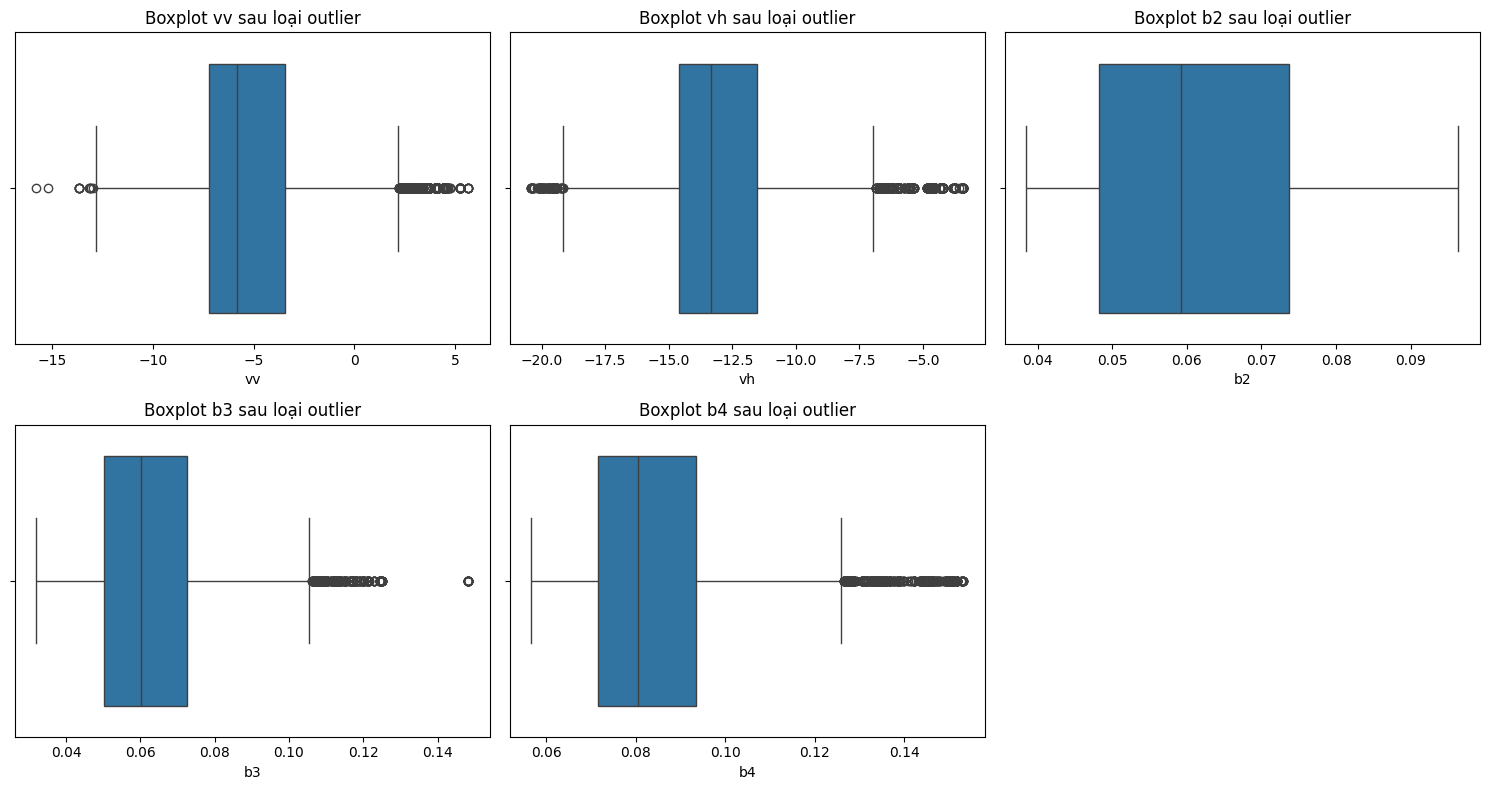

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 8))
for i, col in enumerate(feature_cols):
    plt.subplot(2, 3, i+1)
    sns.boxplot(x=df_clean[col])
    plt.title(f'Boxplot {col} sau loại outlier')
plt.tight_layout()
plt.show()


In [24]:
# Label 1 là roof (mái nhà), còn lại là không phải mái nhà
df_clean['label_bin'] = df_clean['label'].apply(lambda x: 1 if x == 1 else 0)

# Tách X, y
X = df_clean[feature_cols]
y = df_clean['label_bin']

# Chia train-test 80:20
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Số mẫu train: {len(X_train)}, Số mẫu test: {len(X_test)}")


Số mẫu train: 19280, Số mẫu test: 4821


In [ ]:
from sklearn.svm import SVC

# Chọn kernel RBF, C=1.0, gamma='scale' là điểm khởi đầu phổ biến
svm = SVC(
    kernel='rbf',       
    C=1.0,             
    gamma='scale',     
    probability=False,  
    random_state=42  
)
svm.fit(X_train, y_train)

SVC(random_state=42)

In [32]:
y_pred_svm = svm.predict(X_test)

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

cm_svm = confusion_matrix(y_test, y_pred_svm)
tn, fp, fn, tp = cm_svm.ravel()
print("Confusion Matrix:\n", cm_svm)
print(f"TP: {tp}, TN: {tn}, FP: {fp}, FN: {fn}")

print(f"Accuracy : {accuracy_score(y_test, y_pred_svm):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_svm):.4f}")
print(f"Recall   : {recall_score(y_test, y_pred_svm):.4f}")
print(f"F1-Score : {f1_score(y_test, y_pred_svm):.4f}")

Confusion Matrix:
 [[ 230 1453]
 [ 110 3028]]
TP: 3028, TN: 230, FP: 1453, FN: 110
Accuracy : 0.6758
Precision: 0.6757
Recall   : 0.9649
F1-Score : 0.7949


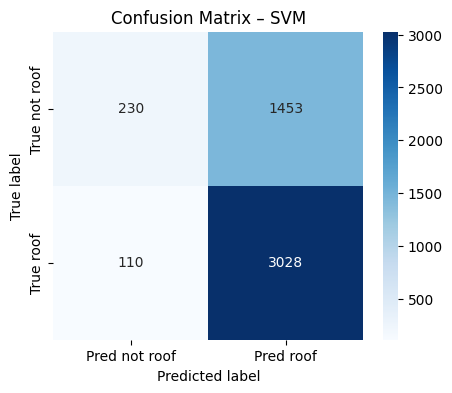

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

# — Heatmap Confusion Matrix —
plt.figure(figsize=(5,4))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pred not roof','Pred roof'],
            yticklabels=['True not roof','True roof'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix – SVM')
plt.show()